# Introducrtion to Machine Learning: Assignment #4
## Submission date: 31\07\2024, 23:55.
### Topics:
- Ensemble methods
- AdaBoost
- PCA
- LDA
- K means clustering

Submitted by:

 Raneem Ibraheem 212920896

 Selan Abu Saleh 212111439

**Assignment Instruction:**

· Submissions in pairs only.

· Try to keep the code as clean, concise, and short as possible

· If you wish to work in your IDE, you can, but you **must**,  insert the script back to the matching cells of the notebook and run the code. <br/>Only the notebook will be submitted in moodle (in `.ipynb` format).

· <font color='red'>Please write your answers to question in red</font>.

**Important:** All plots, results and outputs should be included in the notebook as the cells' outputs (run all cells and do not clear the output). <br/>

**Important:** Your submission must be entirely your own. Any attempts of plagiarism (including ChatGPT) will lead to grade 0 and disciplinary actions.


## Question 1 - Bagging
In HW3, you helped Charles Darvin with regression of abalone problem and now, you will try combining multiple regression models instead of just one, hopefully for a better result.

In [1]:
# import libraries

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()

In [2]:
# load the data, transform it

df = pd.read_csv('https://sharon.srworkspace.com/ml/datasets/hw3/abalone.csv', header=None)
data = df.to_numpy()

train, test = train_test_split(data, test_size=0.2, random_state=21)

X_train, y_train = train[:,:-1], train[:, -1]
X_test, y_test = test[:,:-1], test[:, -1]

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Your task is to complete the following bagging model. Specifically:
- fit(self, data, targets) - train n_estimators regressors, each with data in size n=len(data) that is drawn from the original data, with repititions.
- predict(self, test) - predict the result for all the regressors as learned.



In [3]:
from sklearn.linear_model import LinearRegression

class LinRegCombiner():
    def __init__(self, n_estimators):
        self.n_estimators = n_estimators

    def fit(self, data, targets):
        self.regressors = []
        samples_num = data.shape[0]

        for _ in range(self.n_estimators):
            # Implement here
            indecis = np.random.choice(samples_num, samples_num, replace=True)
            sample_data  = data[indecis]
            sample_targets = targets[indecis]

            regression = LinearRegression()
            regression.fit(sample_data, sample_targets)
            self.regressors.append(regression)


    def predict(self, test):
        preds = np.zeros((self.n_estimators, test.shape[0]))
        # Implement here
        for i, regressor in enumerate(self.regressors):
            preds[i] = regressor.predict(test)
            
        return preds.mean(axis=0)

    def score(self, test, targets):
        temp = self.predict(test)
        return np.mean((targets - temp) ** 2)

In [10]:
# Run for 100 estimators

obj = LinRegCombiner(n_estimators=100)
obj.fit(X_train, y_train)

mse = obj.score(X_train, y_train)
print(f'MSE train = {mse}')

mse = obj.score(X_test, y_test)
print(f'MSE test = {mse}')

MSE train = 4.810868257677657
MSE test = 5.377196982771384


Now, implement the same but using ridge regression

In [11]:
from sklearn.linear_model import Ridge
from sklearn.base import BaseEstimator, RegressorMixin

class RidgeLinRegCombiner(BaseEstimator, RegressorMixin):
    def __init__(self, n_estimators, alpha=1.0):
        self.n_estimators = n_estimators
        self.alpha = alpha

    def fit(self, data, targets):
        self.regressors = []
        samples_num = data.shape[0]
        
        for _ in range(self.n_estimators):
            # Implement here
            indecis = np.random.choice(samples_num, samples_num, replace=True)
            sample_data  = data[indecis]
            sample_targets = targets[indecis]

            regression = Ridge(alpha=self.alpha)
            regression.fit(sample_data, sample_targets)
            self.regressors.append(regression)

    def predict(self, test):
        preds = np.zeros((self.n_estimators, test.shape[0]))
        # Implement here
        for i, regressor in enumerate(self.regressors):
            preds[i] = regressor.predict(test)

        return preds.mean(axis=0)

    def score(self, test, targets):
        temp = self.predict(test)
        return np.mean((targets - temp) ** 2)

Tune the hyperparameters for RidgeLinRegCombiner.

In [21]:
# Implement here
from sklearn.model_selection import RandomizedSearchCV

parameters = {
    'n_estimators': [50, 100, 150, 200],
    'alpha': [0.1, 1.0, 10.0]
}

estimator = RidgeLinRegCombiner(n_estimators=100, alpha=1.0)

search = RandomizedSearchCV(estimator, parameters, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=33)
search.fit(X_train, y_train)

params = search.best_params_
n = params['n_estimators']
alpha = params['alpha']

Print both MSEs on train and test.
Which model is better for our problem? <br/>
<font color='red'>Write your answer here and explain it</font>

In [24]:
# Run for n estimators and alpha you found

obj = RidgeLinRegCombiner(n_estimators=n, alpha=alpha)
obj.fit(X_train, y_train)

mse = obj.score(X_train, y_train)
print(f'MSE train = {mse}')

mse = obj.score(X_test, y_test)
print(f'MSE test = {mse}')

MSE train = 4.80656630974397
MSE test = 5.381097139686271


## Question 2 - Clustering

We learned in the tutorials about partitional clustering and specifically – k means algorithm. <br/>
In this question you will implement it and see some nice applications.

import libraries

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

Complete the missing implementation of Kmeans. Since there are k clusters, we will label each point with {0,..,k-1}.

In [26]:
class Kmeans:

	def __init__(self, n_clusters, max_iter=100, random_state=123):
		self.n_clusters = n_clusters
		self.max_iter = max_iter
		self.random_state = random_state

	def initialize_centroids(self, X):
		np.random.RandomState(self.random_state)
		random_idx = np.random.permutation(X.shape[0])
		centroids = X[random_idx[:self.n_clusters]]
		return centroids

	def reassign_centroids(self, X, labels):
		centroids = np.zeros((self.n_clusters, X.shape[1]))
		# Implement here
		for i in range(self.n_clusters):
			centroids[i, :] = np.mean(X[labels==i], axis=0)
		return centroids

	def compute_distance(self, X, centroids):
		distance = np.zeros((X.shape[0], self.n_clusters))
		for k in range(self.n_clusters):
			row_norm = np.linalg.norm(X - centroids[k, :], axis=1)
			distance[:, k] = np.square(row_norm)
		return distance

	def find_closest_cluster(self, distance):
		return np.argmin(distance, axis=1)

	def compute_sse(self, X, labels, centroids):
		distance = np.zeros(X.shape[0])
		for k in range(self.n_clusters):
			distance[labels == k] = np.linalg.norm(X[labels == k] - centroids[k], axis=1)
		return np.sum(np.square(distance))

	def fit(self, X):
		self.centroids = self.initialize_centroids(X)
		for i in range(self.max_iter):
			old_centroids = self.centroids
			# For each point, calculate distance to all k clustes.
			dist = self.compute_distance(X, self.centroids)
			self.labels = self.find_closest_cluster(dist)
			self.centroids = self.reassign_centroids(X, self.labels)
			if np.all(old_centroids == self.centroids):
				break
		self.error = self.compute_sse(X, self.labels, self.centroids)

	def predict(self, X):
		distance = self.compute_distance(X, self.centroids)
		return self.find_closest_cluster(distance)

Load exams data, convert to numpy and plot it

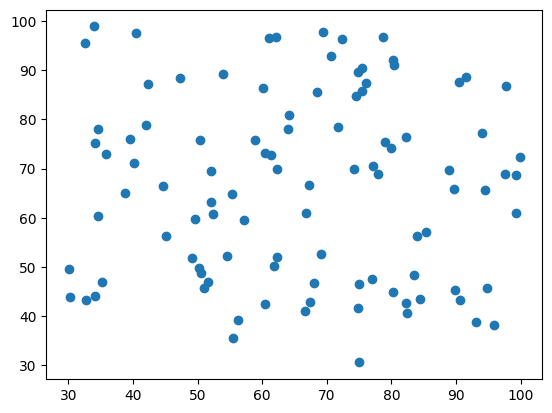

In [27]:
db = pd.read_csv('https://sharon.srworkspace.com/ml/datasets/hw4/exams.csv', header=None).to_numpy()
data, labels = db[:,:-1], db[:,-1]

plt.scatter(data[:, 0], data[:, 1])
plt.show()

We are going to divide the data into 2 clusters. <br/>
Define Kmeans object and fit the data.

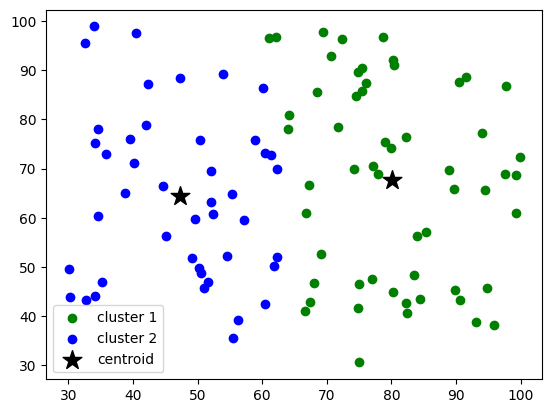

In [28]:
clust = Kmeans(n_clusters=2)
clust.fit(data)

# This code plots the clustered data with centroids
labels = clust.labels
centroids = clust.centroids

c0 = data[labels == 0]
c1 = data[labels == 1]

plt.scatter(c0[:,0], c0[:,1], c='green', label='cluster 1')
plt.scatter(c1[:,0], c1[:,1], c='blue', label='cluster 2')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=200, c='black', label='centroid')
plt.legend()

plt.show()

Use the Elbow Method to choose another number of centroids between 1-10. <br/>
<font color='red'>Explain your choice</font>

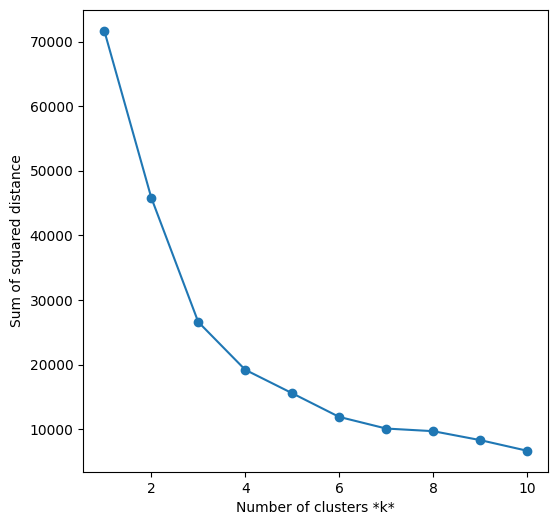

In [30]:
sse = []
list_k = list(range(1, 11))

for k in list_k:
  kmeans = Kmeans(n_clusters=k)
  kmeans.fit(data)
  error_of_current_clustering=kmeans.error
  sse.append(error_of_current_clustering)

'''Plot sse against k'''
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')
plt.show()

Apply clustering with the selected k

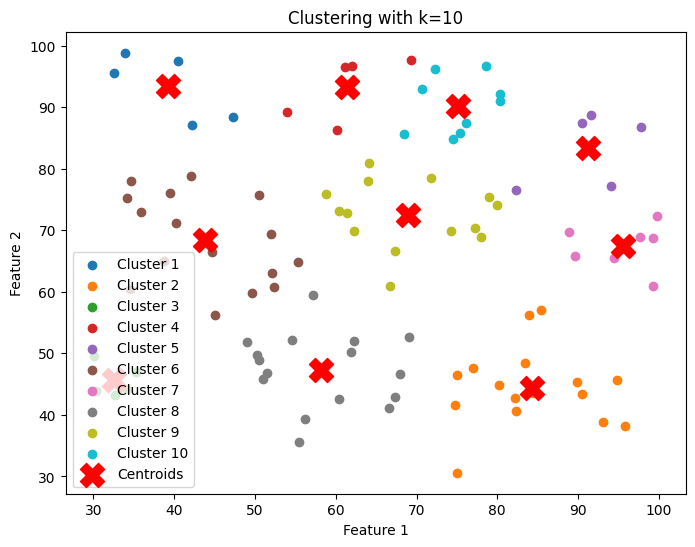

In [34]:
# Implement here
k = 10

# Apply clustering with the selected k
kmeans = Kmeans(n_clusters=k)
kmeans.fit(data)

# Get the cluster labels
labels = kmeans.predict(data)

# Plot the clustered data
plt.figure(figsize=(8, 6))
for i in range(k):
    plt.scatter(data[labels == i, 0], data[labels == i, 1], label=f'Cluster {i+1}')
plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], s=300, c='red', marker='X', label='Centroids')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title(f'Clustering with k={k}')
plt.legend()
plt.show()

Now, you will compress some image using k-means. <br/>
Here, you are given image from size 400x600x3. The last parameter is the number of channels. 3 channels means that the image is colored (unlike 1 in, which is grayscale). <br/>
Our goal is to reduce the number of colors to 20 and represent (compress) the photo using those 20 colors only. <br/>

Motivation: the original image requires 400x600x3x8 bits, while the new image will require only 400x600x5 + 20x24 bits, almost 5 times smaller!<br/>
To really do this, we will take the image and treat every pixel as a data point, where each data point is in 3d space (r,g,b). Then, we cluster into 20 centroids, and we assign each pixel to a centroid. This will allow us to represent the image using only 20 colors.


In [ ]:
#@title helper function

import urllib.request

def read_image(url):
    req = urllib.request.urlopen(url)
    arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
    return cv2.imdecode(arr, -1)

Complete the missing code

In [ ]:
from sklearn.cluster import KMeans
import cv2

img = read_image('https://sharon.srworkspace.com/ml/datasets/hw4/image.jpg')
img_size = img.shape

# Reshape it to be 2-dimension
X = img.reshape(img_size[0] * img_size[1], img_size[2])		# Turn hxwx3 into (h*w)x3

# Run the Kmeans algorithm
km = KMeans(n_clusters=20)
km.fit(X)

'''
The km has the following properties:
(*) km.labels_ is an array size (pixels, 20), will give each pixel its class from 20 classes (values are between 0-19)
(*) km.cluster_centers_ is an array size 20x3, where the ith row represents the color value for the ith label.
	For example, cluster_centers_[0] = [r,g,b], the first center.
'''

# Use the centroids to compress the image
img_compressed = # Use cluster_centers_ and labels_
img_compressed = np.clip(img_compressed.astype('uint8'), 0, 255)

# Reshape X_recovered to have the same dimension as the original image 128 * 128 * 3'''
img_compressed = img_compressed.reshape(img_size[0], img_size[1], img_size[2])

In [ ]:

# Plot the original and the compressed image next to each other'''
plt.figure(figsize = (12, 4))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(img_compressed)
plt.title(f'Compressed Image with {km.n_clusters} colors')

plt.show()

## load smiling dataset

In the third question, we will deal with the Smiling-face dataset, which determines if a person is smiling or not. You will try several models and hope to get good results<br/>
Your task is: run the following section and make sure your understand what's going on.

Go to your <a href="https://www.kaggle.com/">Kaggle</a> account and under the settings, generate new API token. <br/>
This will give you the json file, which you will upload here.

In [ ]:
# The script expects you to upload JSON file to it!

! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
! kaggle datasets download chazzer/smiling-or-not-face-data
! unzip -q smiling-or-not-face-data.zip -d data

import libraries

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import os
import cv2

import warnings
warnings.filterwarnings('ignore')

process the images

In [ ]:
def proccess_data(folder):
	image_arrays = []
	for filename in os.listdir(folder):
		file_path = os.path.join(folder, filename)
		image = cv2.imread(file_path)
		gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
		image_arrays.append(gray_image)
	return np.array(image_arrays)

smile = proccess_data('./data/smile')
non_smile = proccess_data('./data/non_smile')

dataset = np.vstack((smile,non_smile))
dataset = dataset / 255

labels = [0] * len(smile) + [1] * len(non_smile)
labels = np.array(labels)

display smiling and non-smiling image.

In [ ]:
plt.subplot(121)
plt.title("Smile")
plt.imshow(smile[0], cmap='gray')

plt.subplot(122)
plt.title("Not smile")
plt.imshow(non_smile[0], cmap='gray')

plt.show()

print the smiling and non-smiling data + the united dataset along with labels.

In [ ]:
print(f'smile array size is (images, height, width)={smile.shape}')
print(f'non smile array size is (images, height, width)={non_smile.shape}')
print()
print(f'dataset array size is {dataset.shape}')
print(f'labels array size is {labels.shape}')

Prepear train and test datasets, print their structure. Since you have to deal with 1d features, we flatten the squared image

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(dataset, labels, test_size = 0.2, stratify=labels, random_state=42)

print(f'train size is {x_train.shape} and labels size is {y_train.shape}')
print(f'test size is {x_test.shape} and labels size is {y_test.shape}')
print()

x_train_flatten = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])
x_test_flatten = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])

print(f'flattened train size is {x_train_flatten.shape} ')
print(f'flattened test size is {x_test_flatten.shape}')

## Question 3 - PCA, LDA

You will try to classify the smiling faces dataset using feature reduction and KNN (since there are 4096 features!). Than you will compare it to LDA

import libraries

In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

Implement PCA to reduce the dimension of the images from 4096=64x64 to 81=9x9. For time effciency, DONT use any loops here.

Hint: Implement inverse_transform to recover the original vector from the compressed one. <br/>
Hint: When dealing with symmetric matrix, you can call eigh instead of eig function of numpy, its much faster.

In [4]:
def PCA_train(data, k):
	# Implement here
	# Download data to k dimensions
	mean = np.mean(data, axis=0)
	proccessed_data = data - mean
	cov_mat = np.cov(proccessed_data, rowvar= False)
	eigenVal, eigenVec = np.linalg.eigh(cov_mat)
	sorted_i = np.argsort(eigenVal)[::-1]
	eigenVal = eigenVal[sorted_i]
	eigenVec = eigenVec[:,sorted_i]
	largest_K_Vec = eigenVec[:,:k]
	x_train_new = np.dot(proccessed_data, largest_K_Vec)
	return x_train_new, mean, largest_K_Vec
def PCA_test(test, mu, E):
	# Implement here
	processed_test = test - mu
	return np.dot(processed_test, E)

def recover_PCA(data, mu, E):
	# Implement here
	return np.dot(data, E.T) + mu

Apply the PCA. <br/>
Make sure you fit the PCA model only to the training set (but apply it to both training and test sets). <br/>

In [ ]:
x_train_new, mu, eig = # Implement here
x_test_new = # Implement here

Pick another random image and show the result of applying PCA to it, and then try to recover the whole size again.

In [ ]:
plt.subplot(131)
plt.title("Original Image")
plt.imshow(None, cmap='gray')

plt.subplot(132)
plt.title("Image in lower dimension")
plt.imshow(None, cmap='gray')

plt.subplot(133)
plt.title("Recovered Image")
plt.imshow(None, cmap='gray')

plt.show()

Before training the model, use EIG_CDF, that given eigenvalues, draws a CDF of them like here:<br/><br/>

![Picture1.jpg](https://encrypted-tbn1.gstatic.com/images?q=tbn:ANd9GcS3mOZk1x4X3ap9nuMnst5W5pMgOXF8r3Tmx1QcFX9mba_lleuB)

As seen in the tutorials, we use them to see how much "energy" we preserve from the data. Use this to choose optimal dimension to reduce into, such the preserves 95% of the energy.

In [ ]:
def EIG_CDF(eig_list):
	sorted_eigenvalues = np.sort(eig_list)[::-1]

	eigenvalues_cumsum = np.cumsum(sorted_eigenvalues)

	eigenvalues_cumsum_normalized = eigenvalues_cumsum / eigenvalues_cumsum[-1]
	amount = # Implement here

	plt.plot(np.arange(1, len(sorted_eigenvalues)+1), eigenvalues_cumsum_normalized)
	plt.xlabel('Principal Component')
	plt.ylabel('Cumulative Proportion of Variance')
	plt.title(f'CDF of Eigenvalues - {amount} eigs preserves 95% of enetry')
	plt.show()

# Call to EIG_CDF

For the same image as before, show the result of applying PCA to it and recovering.<br/>
Is the result better? What is different from 81 dimensions? <br/>
<font color='red'>Write here your answer and explain it</font>

In [ ]:
plt.subplot(131)
plt.title("Original Image")
plt.imshow(None, cmap='gray')

plt.subplot(132)
plt.title("Image in lower dimension")
plt.imshow(None, cmap='gray')

plt.subplot(133)
plt.title("Recovered Image")
plt.imshow(None, cmap='gray')

plt.show()

Now, you are ready to train the model. Use KNN, tune the best k using cross_val_score (with sklearn)

In [ ]:
# Implement here

plt.figure(figsize=(14,5))
plt.plot(ks, accs)
plt.xlabel('k')
plt.xticks(ks)
plt.ylabel('avg accuracy')
plt.show()

Print the accuracy of your model on the test set.

In [ ]:
# Implement here
print(f'acc on test is {acc}')

Answer the following sum-up questions: <br/>
- What pre-proccessing actions were done on the data?
- Should we apply Standard Scaler? Why?
- Suggest one idea for improvement (rather than LDA)

<font color='red'>Write here your answers, with explainations</font>


For the second part, we will use LDA on the data <b>before</b> PCA. <br/>
Use the model of LinearDiscriminantAnalysis from Sklearn, train the data and print the accuracy test using KNN. <br/>
Use the best k you found earlier.

In [ ]:
# Implement here

Now, repeat the same as above, but using the data <b>after</b> PCA and using the same k.
- Was the combination of PCA and LDA helpful more than LDA alone?
- Comparing LDA alone vs PCA alone (as dimensionality reduction), which one was better to this problem? Justify.

<font color='red'>Write your answers here and explain them.</font>

## Question 4 - Adaboost
See attached pdf in moodle assignment!



## Question 5 - Kernel PCA - 10 pts bonus
See attached pdf in moodle assignment! <br/>
Here you will implement the parts that are relevant for that question

In [ ]:
# Implement here everything you need